In [1]:
import sqlite3
import pandas as pd
import os
import re
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.metrics import accuracy_score, roc_curve, auc,  precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from nltk.tokenize import sent_tokenize, word_tokenize, StanfordTokenizer
from nltk.corpus import stopwords
#from bs4 import BeautifulSoup
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
import string
import seaborn as sns
sns.set_style("whitegrid")
os.chdir('/Users/RayLJazz/Dropbox/iidata')

In [2]:
ffclean = pd.read_csv('cleaned_food.csv')

In [3]:
ffclean.shape, ffclean.columns

((31149, 16),
 Index(['packaging_cleaned', 'catgory_cleaned', 'quan_unit', 'additives_n',
        'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
        'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
        'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition_score_fr_100g',
        'nutrition_score_uk_100g'],
       dtype='object'))

In [4]:
Class = []
def identify_class(row):
    if (row['ingredients_that_may_be_from_palm_oil_n']==np.nan):
        Class.append(np.nan)
    elif (row['ingredients_that_may_be_from_palm_oil_n']==0):
        Class.append(int(0))
    else:
        Class.append(int(1))

In [5]:
ffclean_class = ffclean.apply(identify_class,axis=1)

In [6]:
Class_df = pd.Series(data=Class)
ffclean['palm_Class'] = Class_df
ffclean['palm_Class'].value_counts()

0    25711
1     5438
Name: palm_Class, dtype: int64

In [7]:
Class_char = pd.Categorical.from_codes(ffclean['palm_Class'], ['No', 'Yes'])
ffclean['Class_char'] = Class_char
ffclean_NA=ffclean.replace('NA', np.nan)
ffclean_NA=ffclean.replace('NaN', np.nan)
#ffclean_rna = ffclean_NA.dropna(axis=0, how='any')
ffclean_rna = ffclean

In [8]:
ffclean_rna.shape,ffclean_rna.columns

((31149, 18),
 Index(['packaging_cleaned', 'catgory_cleaned', 'quan_unit', 'additives_n',
        'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
        'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
        'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition_score_fr_100g',
        'nutrition_score_uk_100g', 'palm_Class', 'Class_char'],
       dtype='object'))

In [48]:
ffclean_rna.head(n=10)
target = 'palm_Class'
Predictors = [x for x in ffclean.columns if x not in ['ingredients_that_may_be_from_palm_oil_n','quan_unit','Class_char','palm_Class','packaging_cleaned']]
Predictors 

['catgory_cleaned',
 'additives_n',
 'energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition_score_fr_100g',
 'nutrition_score_uk_100g']

In [49]:
ffclean_rna.shape

(31149, 18)

In [50]:
train_x, test_x, train_y, test_y = cross_validation.train_test_split(ffclean_rna[Predictors], ffclean_rna['palm_Class'], test_size=0.3,random_state=1,stratify=ffclean_rna['palm_Class'])

In [51]:
train_y.value_counts(),  test_y.value_counts()

(0    17997
 1     3807
 Name: palm_Class, dtype: int64, 0    7714
 1    1631
 Name: palm_Class, dtype: int64)

In [52]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((21804, 13), (9345, 13), (21804,), (9345,))

## Extreme Gradient Boosting

### Step 1- Find the number of estimators for a high learning rate

In [53]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [54]:
train = train_x
train['Class'] = train_y
test = test_x
test['Class'] = test_y
target = 'Class'

In [55]:
def modelfit(alg, dtrain, dtest, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_round=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values,missing=np.nan)
        xgtest = xgb.DMatrix(dtest[predictors].values,missing=np.nan)
        xgb_param_forcv = xgb_param
        #xgb_param_forcv['num_class'] = 5
        cvresult = xgb.cv(xgb_param_forcv, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             early_stopping_rounds=early_stopping_round, show_progress=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='error')
    
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    return alg, dtrain_predictions, dtrain_predprob
   

In [56]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
xgb1, dtrain_predictions, dtrain_predprob = modelfit(xgb1, train, test, Predictors,target)

Will train until cv error hasn't decreased in 50 rounds.
/Users/RayLJazz/miniconda3/lib/python3.5/xgboost/training.py:272: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  idset = [randidx[(i * kstep): min(len(randidx), (i + 1) * kstep)] for i in range(nfold)]
[0]	cv-test-error:0.1166758+0.026197048157378344	cv-train-error:0.1140504+0.027559885722549728
[1]	cv-test-error:0.101312+0.003968402550145332	cv-train-error:0.0975396+0.003181408027902112
[2]	cv-test-error:0.1010828+0.006229722510674132	cv-train-error:0.0971838+0.0016324437386936212
[3]	cv-test-error:0.09956960000000001+0.006879851207693375	cv-train-error:0.09505140000000001+0.0006086436067190728
[4]	cv-test-error:0.0983772+0.0058901666665723456	cv-train-error:0.09446659999999998+0.0017557760221622815
[5]	cv-test-error:0.0986062+0.006100717020154272	cv-train-error:0.09399679999999999+0.001609547190982606
[6]	cv-test-error:0.0985144+0.0058842573227213665	cv-train-

In [57]:
def get_performance(xgbmodel,dtrain,dtest,predictors,dtrain_predictions):
    print ("\nModel Report")
    print ("Train accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    test_result = xgbmodel.predict(dtest[predictors])
    dtest_predprob = xgbmodel.predict_proba(dtest[predictors])[:,1]
    print ("Test accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, test_result))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(dtest[target], dtest_predprob))
    print (pd.crosstab(dtest[target].values, test_result, rownames=['actual'], colnames=['preds']))
    feat_imp = pd.Series(xgbmodel.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='barh', title='Feature Importances').invert_yaxis()
    plt.ylabel('Feature Importance Score')


Model Report
Train accuracy : 0.949
Test accuracy : 0.9158
AUC Score (Train): 0.983314
AUC Score (Test): 0.942012
preds      0     1
actual            
0       7528   186
1        601  1030


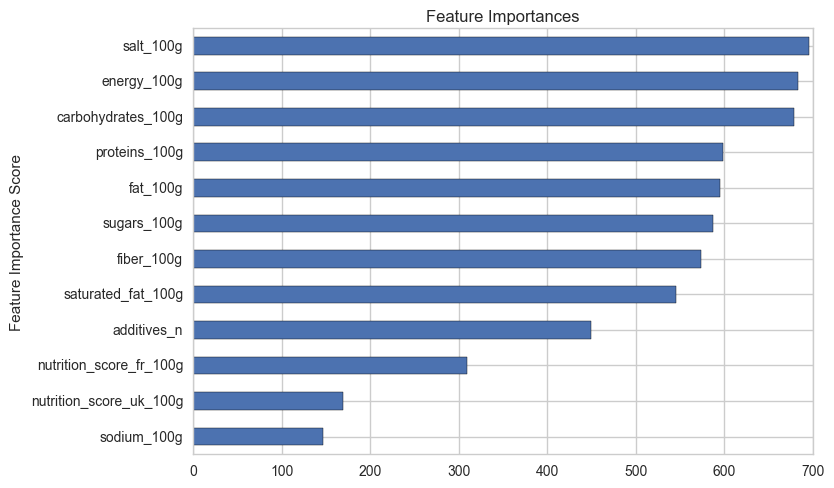

In [58]:
get_performance(xgb1,train,test,Predictors,dtrain_predictions)